In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
t_step = 0.001
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    t_step, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(10,-40,10)]]),\
                    t_step, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) * t_step

Text(0, 0.5, 'Channel')

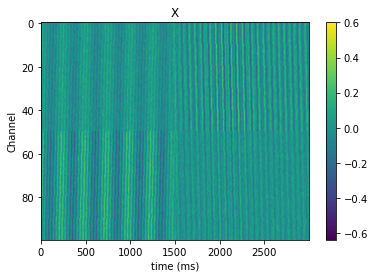

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.title('X')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [4]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.98)
model.fit_opt(x, t)

In [5]:
model.fit_reduction(x, t)

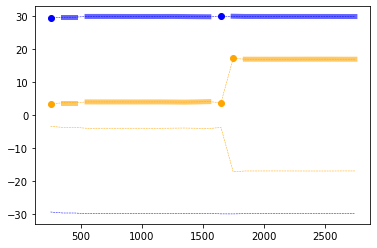

In [5]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange']
for i in range(len(group_idx)):
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])

Text(0, 0.5, 'Cosine Distance')

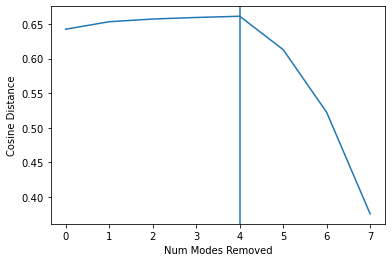

In [11]:
plt.plot(model.errors_)
plt.axvline(4)
plt.xlabel('Num Modes Removed')
plt.ylabel('Cosine Distance')

In [12]:
model.fit_f(x, t, t_step, 4)

/tmp/ipykernel_2282/422705195.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


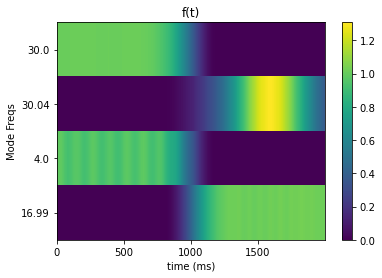

In [13]:
alpha = [str(np.round(f,2)) for f in model.freq_hat_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

Text(0.5, 1.0, 'f(t) vs True f(t)')

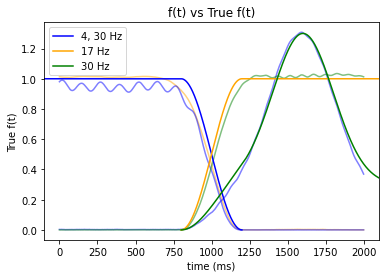

In [14]:
colors = ['orange', 'blue', 'blue', 'green', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,500:-500]):
    plt.plot(f, color=colors[i], alpha=0.5)

plt.plot(t1-500, np.mean(F1_true, axis=0), color=colors[1], label=str(f1)+', '+str(f2)+' Hz')
plt.plot(t3-500, np.mean(F3_true, axis=0), color=colors[0], label=str(f3)+' Hz')
plt.plot(t4-500, np.mean(F4_true, axis=0), color=colors[3], label=str(f4)+' Hz')
plt.legend()
plt.xlim(-100,2100)
plt.xlabel('time (ms)')
plt.ylabel('True f(t)')
plt.title('f(t) vs True f(t)')

In [15]:
x_rec = model.transform(x, t)

Text(0, 0.5, 'Channel')

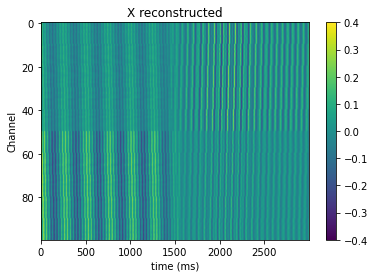

In [16]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

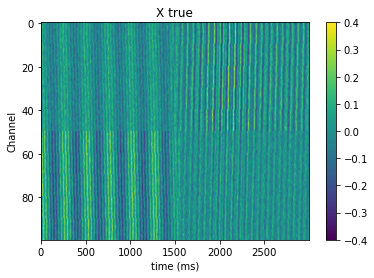

In [17]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')